In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import eigvalsh
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from jax import jit, vmap, grad, value_and_grad

from configs import Lorenz96Config, LorenzSystem
from models import lorenz96_step 
from metrics import rmse, mbe
from plotting import (
    create_dof_slope_plot,
    create_combined_rmse_bias_plot,
    create_mixed_layout_custom,
    create_stacked_bar_plot,
)

from cost_functions import (
    bayes_cost_function,
    dci_cost_function,
    dci_wme_cost_function,
)

import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
jax.config.update("jax_enable_x64", True)

/var/folders/14/4_5vrl2912bc84l063zdm5l80000gq/T/ipykernel_72758/3540166249.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
"""Main execution function"""
# Define cost functions
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}

dofs = [12, 24, 36, 48, 64]
inf_factors = [5, 5, 5,5, 5]
dof_dfs = []
for dof, level in zip(dofs,inf_factors):
    print(f"dof: {dof}, level: {level}")
    # Create system with default configuration
    config_96 = Lorenz96Config.default_config(
                                        state_dim=dof,
                                        obs_dim=dof//2,
                                        total_steps=500,
                                        window_size=20,
                                        obs_frequency=4,
                                        obs_std=1.2,
                                        inflation_factor=level,
                                        seed=13
                                        )
    system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
    system_96.obs_system._setup_observation_operator()
    results_96 = system_96.run_experiment()
    dof_dfs.append(pd.DataFrame.from_dict(results_96['results'], orient='index'))


rmse_dofs = pd.concat(map(lambda df: df.rmse, dof_dfs),axis=1).T.reset_index(drop=True)
rmse_dofs.index = dofs

dof: 12, level: 5
dof: 24, level: 5
dof: 36, level: 5
dof: 48, level: 5
dof: 64, level: 5


In [5]:
rmse_dofs

,Bayes,DCI,DCI_WME
12,0.574385,0.888846,1.010530
24,0.895116,1.538437,0.856875
36,0.805263,1.459292,0.783561
48,1.549806,2.662006,0.873557
64,1.348631,2.702253,0.974939


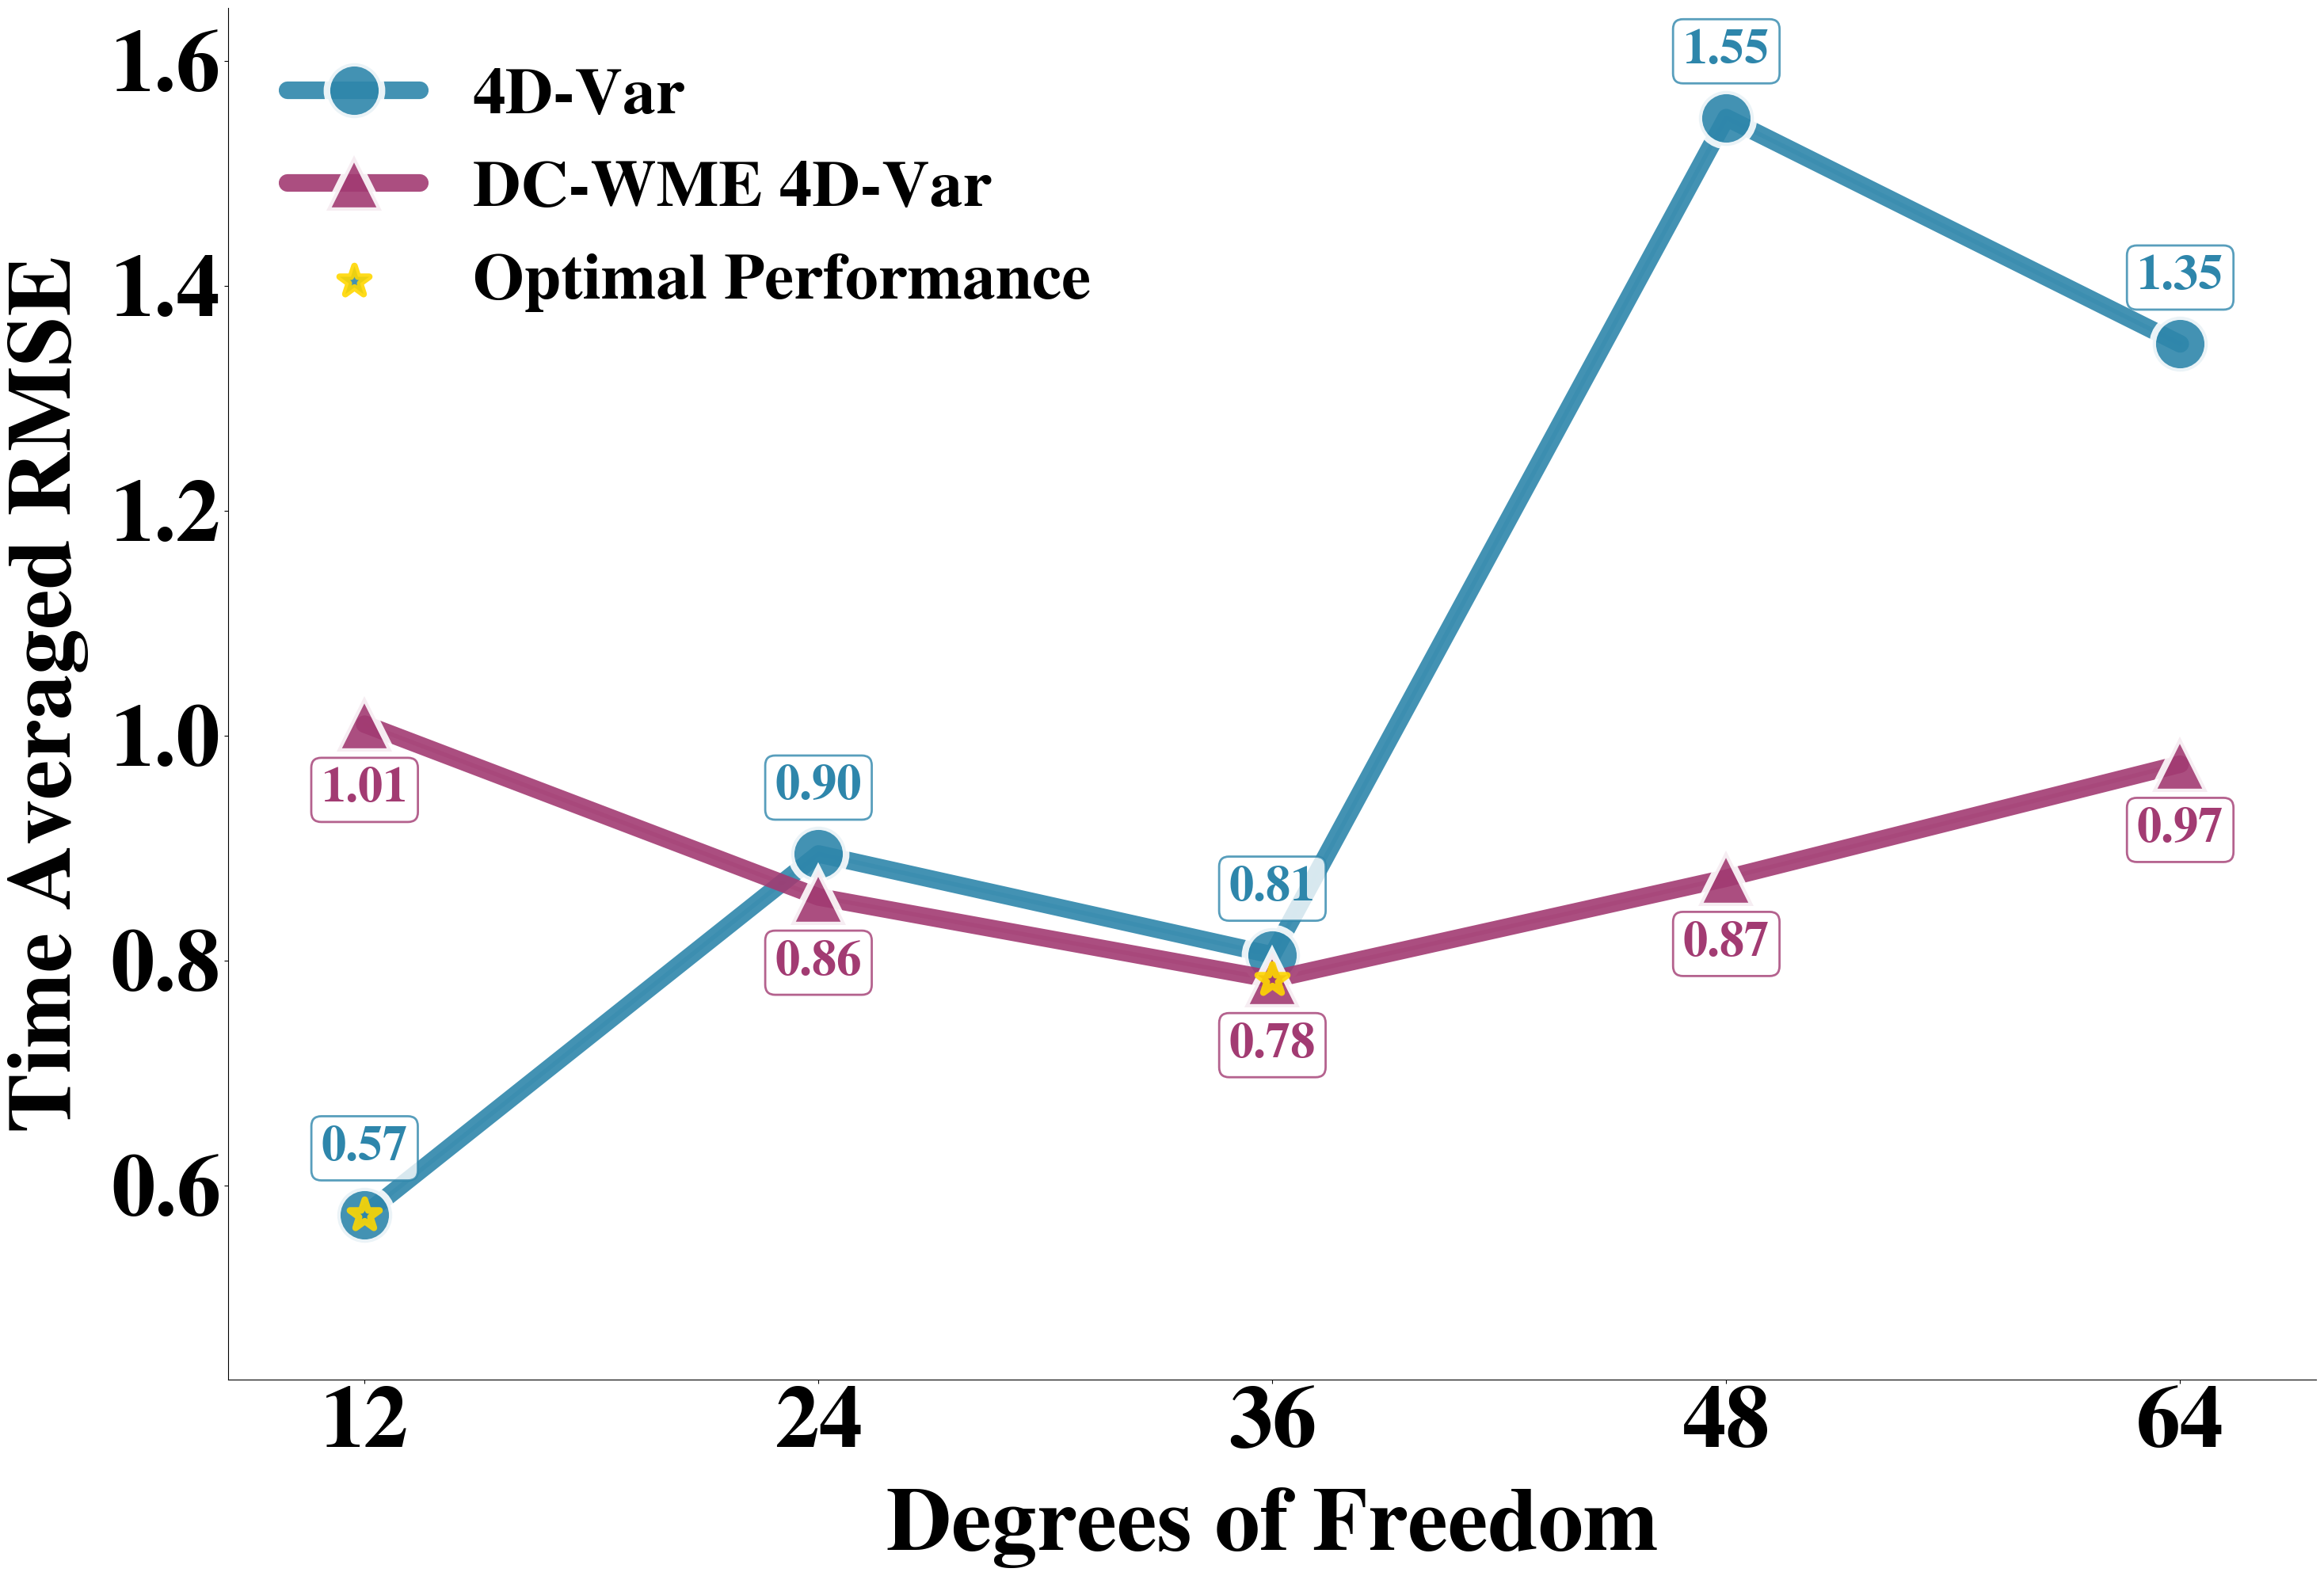

In [ ]:
plot_params = {
    "lines.linewidth": 16,
    "lines.markersize": 50,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 60,
    "legend.frameon": False,
    "xtick.labelsize": 80,
    "ytick.labelsize": 80,
    "axes.labelsize": 82,
    "axes.labelpad": 20,
    "axes.titlesize": 50,
    "figure.figsize": (30, 20),
}

# Define colors and styles for each model
colors = {
    '4D-Var': '#2E86AB',
    'DC-WME 4D-Var': '#A23B72'
}


markers = {
    '4D-Var': 'o',
    'DC-WME 4D-Var': '^'
}

model_labels = ['4D-Var', 'DC-WME 4D-Var']

save = True

create_dof_slope_plot(rmse_dofs, dofs, model_labels,colors, markers, plot_params, save=False)  # Multi-point version

____

In [2]:
# Define cost functions
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}



config_96 = Lorenz96Config.default_config(
                                    state_dim=48,
                                    obs_dim=48//2,
                                    total_steps=1000,
                                    window_size=20,
                                    obs_frequency=4,
                                    obs_std=1.2,
                                    inflation_factor=5,
                                    seed=13
                                    )
system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
system_96.obs_system._setup_observation_operator()

results_avg_96 = system_96.run_experiment()
df_avg_96 = pd.DataFrame.from_dict(results_avg_96['results'], orient='index')
df_avg_96

,rmse,relative_error,misfit
Bayes,1.650961,0.329878,16.606234
DCI,2.721968,0.518579,23.046683
DCI_WME,0.730974,0.137036,19.934239


In [4]:
plot_params = {
    "lines.linewidth": 2,
    "lines.markersize": 5,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 20,
    "legend.frameon": False,
    "legend.title_fontsize": "50",
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 25,
    "figure.figsize": (15, 12),
}

# Colors
background_color = "#3B4CC0"  # Indigo
analysis_color   = "#FABD2F"  # Muted yellow-orange
pos_color = "#1FA187"         # Sea Green
neg_color = "#D43D51"         # Scientific red

# Normalization helper
def normalize_series(series):
    max_abs = np.max(np.abs(series))
    if max_abs == 0:
        return series, 1.0
    return series / max_abs, max_abs

models = list(cost_functions.keys())

# Compute scores
rmse_scores_background = {m: rmse(results_avg_96['backgrounds'][m], results_avg_96['trajectory']) for m in models}
bias_scores_background = {m: mbe(results_avg_96['backgrounds'][m], results_avg_96['trajectory']) for m in models}
rmse_scores_analysis = {m: rmse(results_avg_96['analysis'][m], results_avg_96['trajectory']) for m in models}
bias_scores_analysis = {m: mbe(results_avg_96['analysis'][m], results_avg_96['trajectory']) for m in models}

# Convert to DataFrames
rmse_scores_background = pd.DataFrame(rmse_scores_background)
bias_scores_background = pd.DataFrame(bias_scores_background)
rmse_scores_analysis = pd.DataFrame(rmse_scores_analysis)
bias_scores_analysis = pd.DataFrame(bias_scores_analysis)

model_configs = {
    'Bayes': {'title': '4D-Var', 'col': 0},
    'DCI': {'title': 'DC 4D-Var', 'col': 1},
    'DCI_WME': {'title': 'DC-WME 4D-Var', 'col': 2}
}



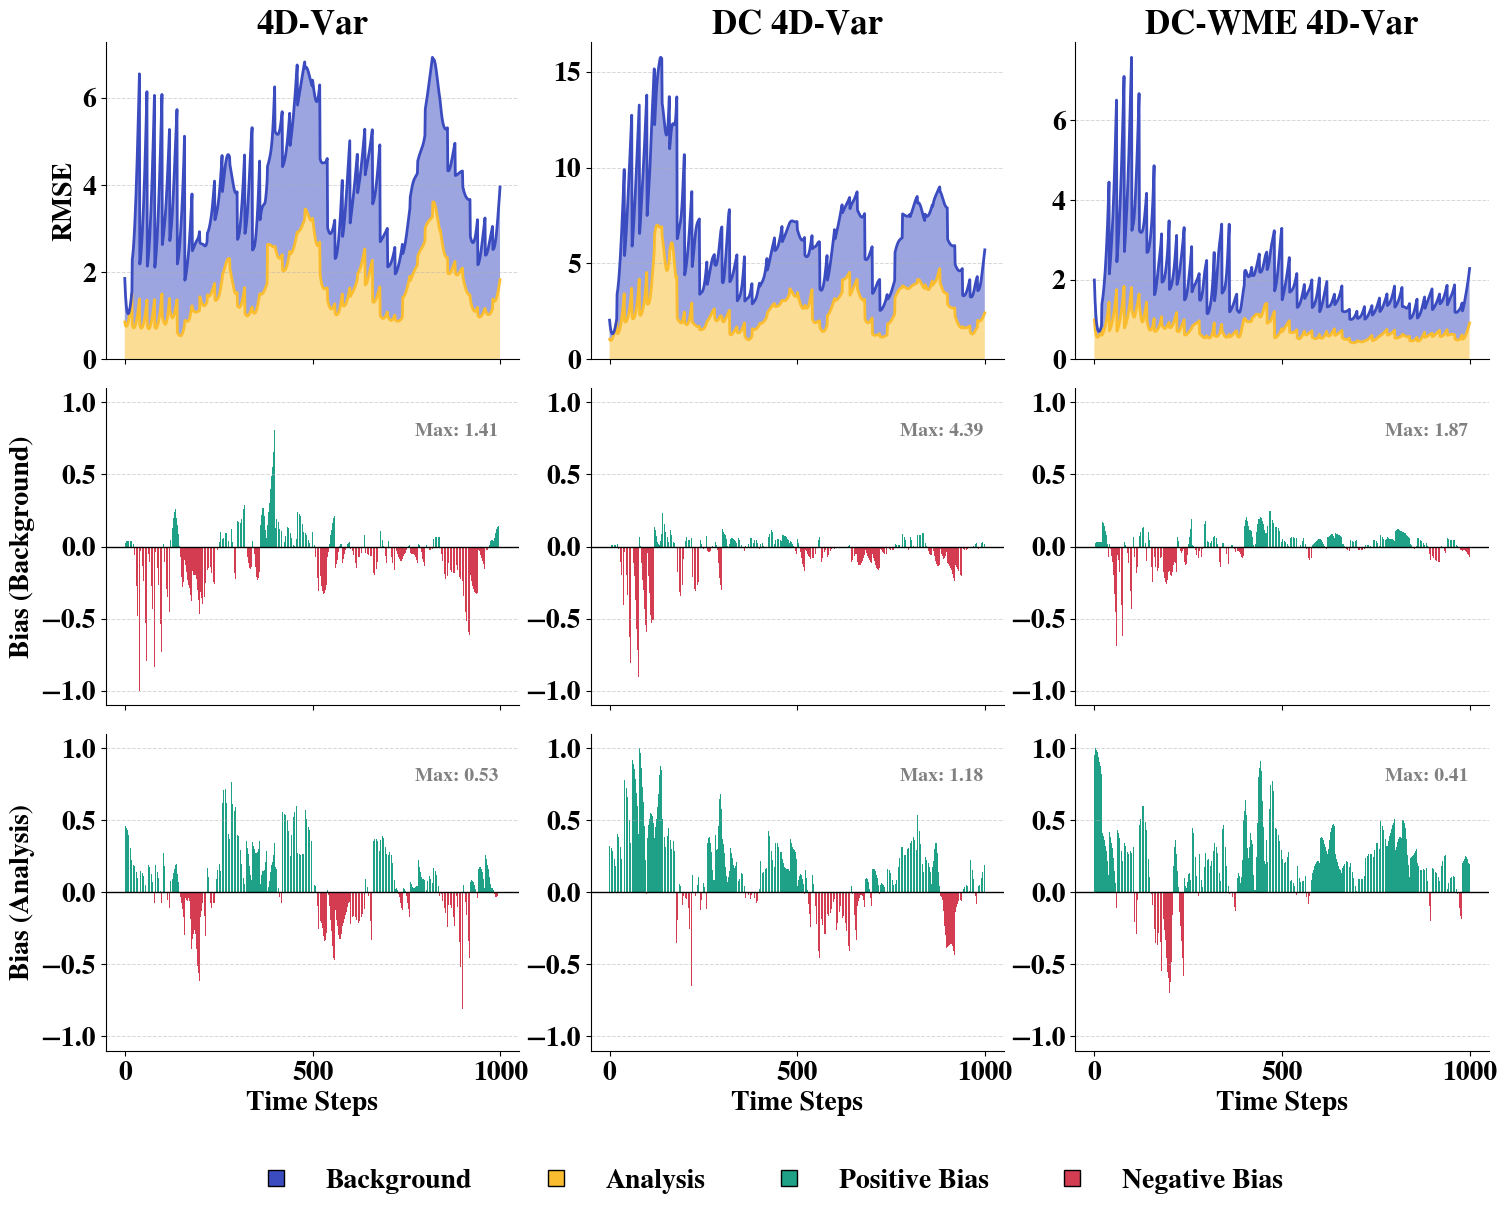

In [5]:
fig, ax = create_combined_rmse_bias_plot(
    rmse_scores_background,
    rmse_scores_analysis,
    bias_scores_background,
    bias_scores_analysis,
    model_configs,
    plot_params,
    normalize_series,
    save_plot=False
)

___

In [6]:
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}
models = list(cost_functions.keys())
rmse_scores_analysis = {}
window_sizes = [2,5,10]
window_size_dfs = []
rmse_scores_dfs = []

for size in window_sizes:
    config_96 = Lorenz96Config.default_config(
                                    state_dim=48,
                                    obs_dim=48//2,
                                    total_steps=1000,
                                    window_size=size,
                                    obs_frequency=1,
                                    obs_std=1.2,
                                    inflation_factor=5,
                                    seed=13
                                    )
    system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
    system_96.obs_system._setup_observation_operator()
    results_window_96 = system_96.run_experiment()


    for model in models:
        rmse_scores_analysis[model] = rmse(results_window_96['analysis'][model], results_window_96['trajectory'])

    rmse_scores_df = pd.DataFrame(rmse_scores_analysis)
    rmse_scores_dfs.append(rmse_scores_df)
    df = pd.DataFrame.from_dict(results_window_96['results'], orient='index')
    window_size_dfs.append(df)

rmse_window = pd.concat(map(lambda df: df.rmse, window_size_dfs), axis=1)
misfit_window = pd.concat(map(lambda df: df.misfit, window_size_dfs), axis=1)
rel_error_window = pd.concat(map(lambda df: df.relative_error, window_size_dfs), axis=1)
misfit_window.columns = window_sizes
rmse_window.columns = window_sizes
rel_error_window.columns = window_sizes


rmse_4dvar = {size: df['Bayes'].values for size, df in zip(window_sizes, rmse_scores_dfs)}
rmse_dci = {size: df['DCI'].values for size, df in zip(window_sizes, rmse_scores_dfs)}
rmse_dci_wme = {size: df['DCI_WME'].values for size, df in zip(window_sizes, rmse_scores_dfs)}

In [7]:
rmse_scores_dfs[0]

,Bayes,DCI,DCI_WME
0,0.886856,1.022592,0.935053
1,0.840126,1.001576,0.896886
2,0.943943,0.953862,0.889435
3,0.923842,0.931523,0.860247
4,1.030526,1.047514,0.851349
...,...,...,...
995,10.047540,9.956816,9.617880
996,10.041695,9.963156,9.465572
997,10.107803,9.973130,9.525935
998,10.114105,9.993223,9.362130


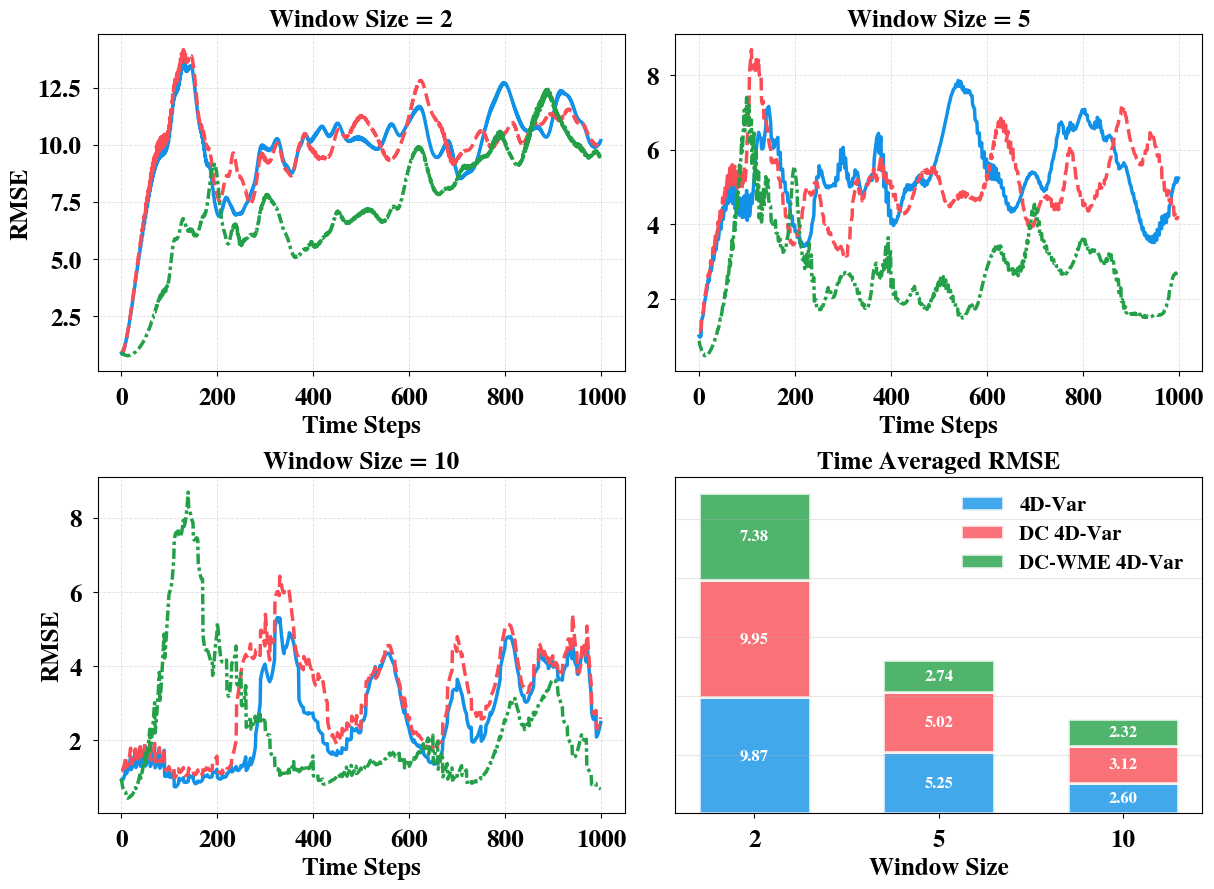

In [12]:
# Time axis
T = 1000
time = np.arange(T)

# Your specified window sizes
window_sizes = [2, 5, 10]

colors = {
    "4D-Var": "#1192e8",       # IBM Blue
    "DC 4D-Var": "#fa4d56",    # IBM Red
    "DC-WME 4D-Var": "#24a148" # IBM Green
}

plot_params = {
    "lines.linewidth": 3,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 15,
    "legend.frameon": False,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "axes.labelsize": 18,
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
    "figure.figsize": (18,8),
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'mathtext.default': 'bf',
    'font.family': 'STIXGeneral',
    'font.weight': 'bold',
}
create_mixed_layout_custom(time,
                           rmse_4dvar,
                           rmse_dci,
                           rmse_dci_wme,
                           window_sizes,
                           colors,
                           plot_params,
                           save=False)

In [13]:


# # Enhanced with Statistical Information
# def create_timeseries_enhanced_stats(rmse_data, window_sizes, time, colors, save=True):
#     """Enhanced version with rolling averages, confidence intervals, and summary stats"""
    
#     methods = ["4D-Var", "DC 4D-Var", "DC-WME 4D-Var"]
#     line_styles = ['-', '--', (0, (3, 1, 1, 1))]
    
#     fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
#     # Top row: Original time series with rolling averages
#     for idx, window_size in enumerate(window_sizes):
#         ax = axes[0, idx]
        
#         for method_idx, (method, style) in enumerate(zip(methods, line_styles)):
#             data_key = list(rmse_data.keys())[method_idx]
#             data = rmse_data[data_key][window_size]
            
#             # Original line
#             ax.plot(time, data, label=f"{method}", 
#                    color=colors[method], linestyle=style, linewidth=1.5, alpha=0.7)
            
#             # Rolling average (smoothed)
#             window = 50  # Rolling window
#             rolling_mean = pd.Series(data).rolling(window=window, center=True).mean()
#             ax.plot(time, rolling_mean, color=colors[method], linewidth=3, alpha=0.9)
        
#         ax.set_title(f"Window Size = {window_size} (with Rolling Avg)", fontweight='bold')
#         ax.grid(True, alpha=0.3)
#         ax.set_ylabel("RMSE" if idx == 0 else "")
    
#     # Bottom row: Distribution comparisons
#     for idx, window_size in enumerate(window_sizes):
#         ax = axes[1, idx]
        
#         data_for_violin = []
#         labels_for_violin = []
        
#         for method_idx, method in enumerate(methods):
#             data_key = list(rmse_data.keys())[method_idx]
#             data = rmse_data[data_key][window_size]
#             data_for_violin.append(data)
#             labels_for_violin.append(method)
        
#         # Violin plot for distribution comparison
#         parts = ax.violinplot(data_for_violin, positions=range(len(methods)), 
#                              showmeans=True, showmedians=True)
        
#         # Color the violin plots
#         for pc, method in zip(parts['bodies'], methods):
#             pc.set_facecolor(colors[method])
#             pc.set_alpha(0.7)
        
#         ax.set_title(f"RMSE Distributions (Window = {window_size})", fontweight='bold')
#         ax.set_xticks(range(len(methods)))
#         ax.set_xticklabels(methods, rotation=45)
#         ax.set_ylabel("RMSE" if idx == 0 else "")
#         ax.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     if save:
#         plt.savefig('timeseries_enhanced_stats.png', dpi=300, bbox_inches='tight')
#     plt.show()


# # APPROACH 4: Subplot Function with Customizable Features
# def plot_single_timeseries(ax, rmse_data, window_size, time, colors, methods, 
#                           line_styles, show_legend=False, highlight_periods=None):
#     """Reusable function for plotting a single time series subplot"""
    
#     lines = []
#     for method_idx, (method, style) in enumerate(zip(methods, line_styles)):
#         data_key = list(rmse_data.keys())[method_idx]
#         line = ax.plot(time, rmse_data[data_key][window_size], 
#                       label=method, color=colors[method], 
#                       linestyle=style, linewidth=2.5, alpha=0.9)[0]
#         lines.append(line)
    
#     # Optional: Highlight specific time periods
#     if highlight_periods:
#         for start, end, color, alpha in highlight_periods:
#             ax.axvspan(start, end, color=color, alpha=alpha, zorder=0)
    
#     # Styling
#     ax.set_title(f"Window Size = {window_size}", fontweight='bold', pad=15)
#     ax.grid(True, linestyle='--', alpha=0.3)
    
#     # Optional statistics annotation
#     mean_vals = []
#     for method_idx, method in enumerate(methods):
#         data_key = list(rmse_data.keys())[method_idx]
#         mean_val = np.mean(rmse_data[data_key][window_size])
#         mean_vals.append(f"{method}: {mean_val:.3f}")
    
#     # Add text box with statistics
#     stats_text = "Means:\n" + "\n".join(mean_vals)
#     ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
#            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
#     if show_legend:
#         ax.legend(loc='upper right')
    
#     return lines

# def create_timeseries_modular(rmse_data, window_sizes, time, colors, save=True):
#     """Modular approach using reusable subplot function"""
    
#     methods = ["4D-Var", "DC 4D-Var", "DC-WME 4D-Var"]
#     line_styles = ['-', '--', (0, (3, 1, 1, 1))]
    
#     # Define some periods to highlight (example: model spin-up, steady state, etc.)
#     highlight_periods = [(0, 100, 'yellow', 0.2), (800, 1000, 'lightblue', 0.2)]
    
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
#     legend_lines = None
#     for idx, (ax, window_size) in enumerate(zip(axes, window_sizes)):
#         lines = plot_single_timeseries(ax, rmse_data, window_size, time, colors, 
#                                      methods, line_styles, show_legend=False,
#                                      highlight_periods=highlight_periods)
        
#         # Set axis labels
#         ax.set_xlabel("Time Steps", fontweight='bold')
#         if idx == 0:
#             ax.set_ylabel("RMSE", fontweight='bold')
#             legend_lines = lines  # Store for unified legend
    
#     # Unified legend
#     if legend_lines:
#         fig.legend(legend_lines, methods, loc='upper center', 
#                   bbox_to_anchor=(0.5, 0.95), ncol=3, frameon=True)
    
#     plt.tight_layout()
#     if save:
#         plt.savefig('timeseries_modular.png', dpi=300, bbox_inches='tight')
#     plt.show()


# rmse_data = {
#     'rmse_4dvar': rmse_4dvar,
#     'rmse_dci': rmse_dci,
#     'rmse_dci_wme': rmse_dci_wme
# }

# create_timeseries_enhanced_stats(rmse_data, window_sizes, time, colors)

___

In [14]:
"""Main execution function"""
# Define cost functions
cost_functions = {
    'Bayes': bayes_cost_function,
    'DCI': dci_cost_function,
    'DCI_WME': dci_wme_cost_function
}

dofs = [24, 36, 48, 64, 72, 84, 96]
inf_factors = 7 * np.array([1, 1, 1, 1, 1, 1, 1, 1])

comp_costs = {}
dof_dfs = []
for dof, level in zip(dofs,inf_factors):
    print(f"dof: {dof}, level: {level}")
    # Create system with default configuration
    config_96 = Lorenz96Config.default_config(
                                        state_dim=dof,
                                        obs_dim=dof//2,
                                        total_steps=2000,
                                        window_size=20,
                                        obs_frequency=2,
                                        obs_std=0.5,
                                        inflation_factor=level,
                                        seed=98866
                                        )
    system_96 = LorenzSystem(config_96, lorenz96_step, cost_functions)
    system_96.obs_system._setup_observation_operator()
    results_96 = system_96.run_experiment()
    comp_costs[dof] = results_96['timing_results']
    dof_dfs.append(pd.DataFrame.from_dict(results_96['results'], orient='index'))

rmse_dofs = pd.concat(map(lambda df: df.rmse, dof_dfs),axis=1).T.reset_index(drop=True)
rmse_dofs.index = dofs

dof: 24, level: 7
dof: 36, level: 7
dof: 48, level: 7
dof: 64, level: 7
dof: 72, level: 7
dof: 84, level: 7
dof: 96, level: 7


In [15]:
rmse_dofs

,Bayes,DCI,DCI_WME
24,0.490932,0.503780,0.485752
36,0.558200,0.572444,0.431924
48,0.516630,0.529715,0.532471
64,0.526567,0.538942,0.512176
72,0.510093,0.522123,0.557081
84,0.505271,0.517282,0.588365
96,0.509686,0.522330,0.492104


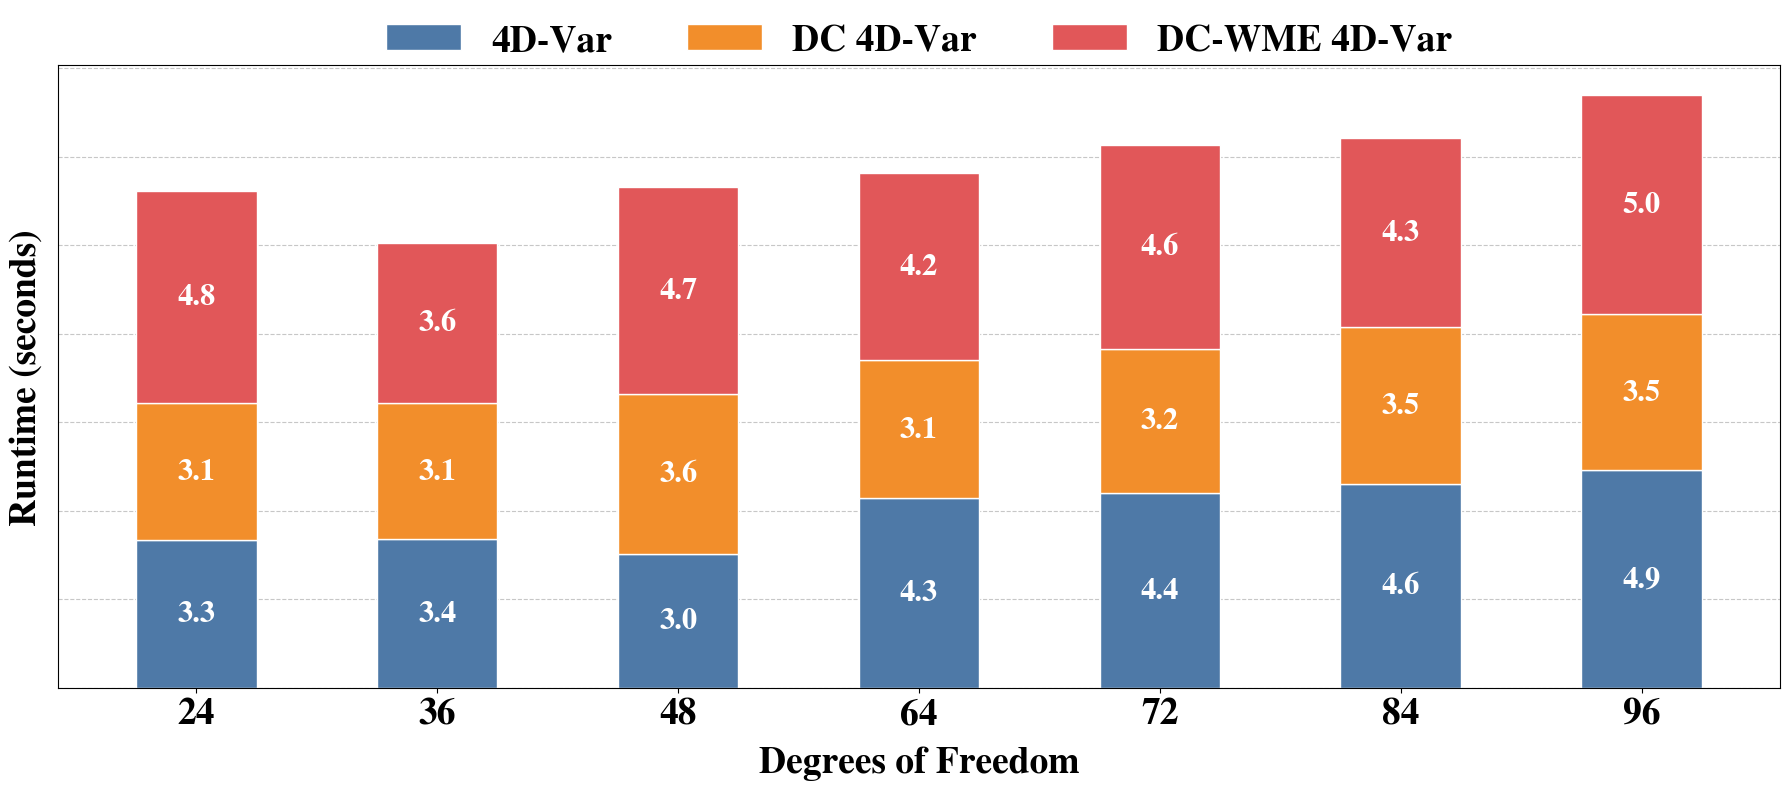

In [21]:
# Extract comp_costs for plotting
degrees_of_freedom = list(comp_costs.keys())
methods = ['4D-Var', 'DC 4D-Var', 'DC-WME 4D-Var']

# Create arrays for each method
bayes_times = [comp_costs[dof]['Bayes'] for dof in degrees_of_freedom]
dci_times = [comp_costs[dof]['DCI'] for dof in degrees_of_freedom]
dci_wme_times = [comp_costs[dof]['DCI_WME'] for dof in degrees_of_freedom]

# Set up the stacked bar chart
x = np.arange(len(degrees_of_freedom))  # the label locations
width = 0.5  # slightly narrower for better separation

# Plot parameters
plot_params = {
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 27,
    "legend.frameon": False,
    "xtick.labelsize": 27,
    "ytick.labelsize": 27,
    "axes.labelsize": 27,
    "axes.labelpad": 10,
    "figure.figsize": (18, 8),
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'mathtext.default': 'bf',
    'font.family': 'STIXGeneral',
    'font.weight': 'bold',
}

save = True
colors = {
    "Bayes": "#4E79A7",     # Blue
    "DCI": "#F28E2B",       # Orange
    "DCI_WME": "#E15759",   # Red
}

times = [bayes_times, dci_times, dci_wme_times]
fig, ax, baras = create_stacked_bar_plot(
    x,
    times,
    methods,
    colors,
    degrees_of_freedom,
    plot_params,
    save_plot=False,
    filename="figures/comp_cost_plot_l96.png"
)




____